# KNN

In [1]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

RANDOM_STATE = 19 * 103785

In [13]:
from preprocesamiento import feature_engineering
from preprocesamiento import obtenerDFHoldout, obtenerDFTraining
from preprocesamiento import preprocesar_data_frame
from sklearn.model_selection import KFold
from sklearn import svm
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

## Prepocesamiento

In [3]:
from sklearn.neighbors import KNeighborsClassifier
df = obtenerDFTraining()
feature_engineering(df)
(X, Y) = preprocesar_data_frame(df)


X1 = pd.get_dummies(X[['ganancia_perdida_declarada_bolsa_argentina','trabajo',
                       'estado_marital','genero',"anios_estudiados"]])

X1 = X1.drop(['trabajo_No contesto'],axis = 1)
X1 = X1.drop(['genero_mujer'],axis = 1)
X1 = X1.drop(['estado_marital_divorciado'],axis = 1)

x_train, x_test, y_train, y_test = train_test_split(X1, Y, test_size=0.25, random_state=RANDOM_STATE)

## Entrenamiendo sin Kfold

In [16]:
def metricas(y_real, y_pred, x_test, knn):

    data = {'y_real': y_real,
            'y_pred': y_pred}

    df_metricas = pd.DataFrame(data, columns=['y_real','y_pred'])
    confusion_matrix = pd.crosstab(df_metricas['y_real'], df_metricas['y_pred'], rownames=['Real'], colnames=['Predicho'])
    sns.heatmap(confusion_matrix, annot=True)
    plt.show()

    print("Recall: {}".format(recall_score(y_real, y_pred)))
    print("Precision: {}".format(precision_score(y_real, y_pred)))
    print("Acc: {}".format(accuracy_score(y_real, y_pred)))
    print("Roc: {}".format(roc_auc_score(y_real, knn.predict_proba(x_test)[:, 1])))
    

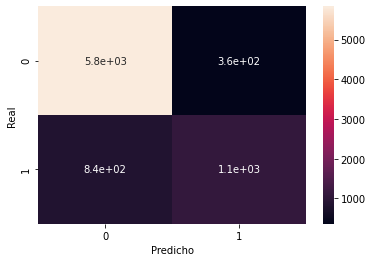

Recall: 0.565599173553719
Precision: 0.7520604395604396
Acc: 0.8521888834235121
Roc: 0.9034439374376431


In [5]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score

knn = KNeighborsClassifier(algorithm = 'brute',n_neighbors=40)
knn.fit(x_train, y_train)
y_pred = knn.predict(x_test)


metricas(y_test,y_pred,x_test)

## Entrenamiendo con Kfold (K=5)

In [6]:
kfold = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
knn = KNeighborsClassifier(algorithm = 'brute',n_neighbors=40)
recal = []
precision = []
acurracy = []
roc = []

for train_index, test_index in kfold.split(Y.ravel()):
     print("TRAIN:", train_index, "TEST:", test_index)
     X_train, X_test = X1.iloc[train_index], X1.iloc[test_index]
     y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]
        
     knn.fit(X_train, y_train)
     y_pred = knn.predict(X_test)
     
     recal.append(recall_score(y_test, y_pred))
     precision.append(precision_score(y_test, y_pred))
     acurracy.append(accuracy_score(y_test, y_pred))
     roc.append(roc_auc_score(y_test, knn.predict_proba(X_test)[:, 1]))
        
        
print("Recall {}".format(np.mean(recal)))
print("Precision {}".format(np.mean(precision)))
print("Acc {}".format(np.mean(acurracy)))
print("Roc {}".format(np.mean(roc)))

TRAIN: [    0     2     3 ... 32524 32525 32526] TEST: [    1     4    10 ... 32482 32494 32506]
TRAIN: [    0     1     3 ... 32523 32525 32526] TEST: [    2    13    15 ... 32517 32519 32524]
TRAIN: [    1     2     4 ... 32523 32524 32525] TEST: [    0     3     7 ... 32510 32522 32526]
TRAIN: [    0     1     2 ... 32524 32525 32526] TEST: [    5     9    18 ... 32516 32518 32523]
TRAIN: [    0     1     2 ... 32523 32524 32526] TEST: [    6     8    26 ... 32520 32521 32525]
Recall 0.5908176552687551
Precision 0.7658990169272519
Acc 0.8579029775152268
Roc 0.9063955872717664


In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

def preprocesar_df_min_max_scaler(X : pd.DataFrame):
    X = pd.get_dummies(X)
    scaler = MinMaxScaler()
    scaler.fit(X)
    return scaler.transform(X)

def preprocesar_df_pca(df , dim):
    #df = feature_engineering(df)
    (X, Y) = preprocesar_data_frame(df)
    X = preprocesar_df_min_max_scaler(X)
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=RANDOM_STATE)
    
    pca = PCA(dim)
    x_train_pca = pd.DataFrame(pca.fit_transform(x_train))
    x_test_pca = pca.transform(x_test)
    
    return (x_train_pca,x_test_pca,y_train,y_test)


parametros = {'n_neighbors' : range(5,100),'weights':['distance'],
              'algorithm':['auto','ball_tree','kd_tree','brute'],}
#'p':[1,2,3]

knn = KNeighborsClassifier()
clf = GridSearchCV(knn, parametros,n_jobs =-1,verbose = 4, cv = 2,scoring = 'f1')

df = obtenerDFTraining()
x_train, x_test, y_train, y_test  = preprocesar_df_pca(df,48)

clf.fit(x_train, y_train)

print(classification_report(y_test,clf.predict(x_test)))
clf.best_params_

Fitting 2 folds for each of 380 candidates, totalling 760 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   32.7s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed: 12.1min
[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed: 31.2min
[Parallel(n_jobs=-1)]: Done 605 tasks      | elapsed: 47.8min
[Parallel(n_jobs=-1)]: Done 760 out of 760 | elapsed: 61.6min finished


NameError: name 'classification_report' is not defined

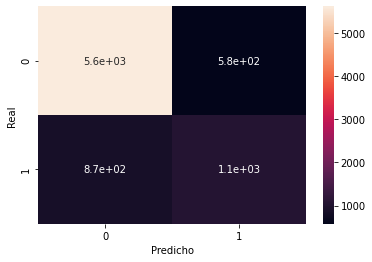

Recall: 0.5485537190082644
Precision: 0.6475609756097561
Acc: 0.8214461387112642
Roc: 0.8526228181738152


In [19]:
df = obtenerDFTraining()
x_train, x_test, y_train, y_test  = preprocesar_df_pca(df,48)

knn_best = KNeighborsClassifier(algorithm = 'brute',n_neighbors= 18,weights = 'distance')
knn_best.fit(x_train, y_train)
y_pred = knn_best.predict(x_test)


metricas(y_test,y_pred,x_test, knn_best)